<a href="https://colab.research.google.com/github/ajaycode/machine-learning/blob/main/FinancialSimulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Financial Simulation
The goal of this notebook is to estimate finances in retirement based on inputs
such as contribution percentages to various account types, investment growth,
required minimum distributions, etc.

The inputs are listed first and projections are performed at the end. Review each
section and update as needed as.

In [ ]:
%%capture
!python -m pip install pandas matplotlib life_model

In [ ]:
from life_model.simulation import Simulation

simulation = Simulation()

## People
This section captures information about the people being studied.

In [ ]:
from life_model.family import Family
from life_model.person import Person, Spending

family = Family(simulation)

john = Person(
    family = family,
    name = 'John',
    age = 44,
    retirement_age = 60,
    spending = Spending(
        base = 12000,
        yearly_increase = 5
    )
)

jane = Person(
    family = family,
    name = 'Jane',
    age = 45,
    retirement_age = 60,
    spending = Spending(
        base = 12000,
        yearly_increase = 5
    )
)

family

## Bank Accounts
Bank accounts associated with each person. These earn a small amount of interest, which may be compounded at different rates, however the rates are much lower than other types of accounts.

In [ ]:
from life_model.account.bank import BankAccount

BankAccount(
    owner = john,
    company = 'Bank',
    type = 'Checking',
    balance = 20000,
    interest_rate = 0.5
)
BankAccount(
    owner = jane,
    company = 'Credit Union',
    type = 'Checking',
    balance = 30000,
    interest_rate = 0.01
)
BankAccount(
    owner = jane,
    company = 'Credit Union',
    type = 'Savings',
    balance = 20100,
    interest_rate = 0.1
)

family

## Jobs
This section captures information about people's jobs.

In [ ]:
from life_model.job import Job, Salary

pizza_papa = Job(
    owner = john,
    company = 'Pizza Papa',
    role = 'Manager',
    salary = Salary(
        base = 50000,
        yearly_increase = 1, # Percent
        yearly_bonus = 1 # Percent
    )
)

bargain_ben = Job(
    owner = jane,
    company = 'Bargain Ben',
    role = 'Manager',
    salary = Salary(
        base = 65000,
        yearly_increase = 3, # Percent
        yearly_bonus = 2 # Percent
    )
)

family

## 401k Accounts
Retirement accounts set up by a company, usually offering some sort of match

In [ ]:
from life_model.account.job401k import Job401kAccount

Job401kAccount(
    job = pizza_papa,
    pretax_balance = 100000,
    pretax_contrib_percent = 15,
    roth_balance = 100000,
    roth_contrib_percent = 5,
    average_growth = 5, # Percent
    company_match_percent = 50
)

Job401kAccount(
    job = bargain_ben,
    pretax_balance = 50000,
    pretax_contrib_percent = 15,
    average_growth = 5, # Percent
    company_match_percent = 0
)


## Housing
This section captures housing details.

In [ ]:
from life_model.housing.home import Home, Mortgage, HomeExpenses

home = Home(
    person = john,
    name = "John and Jane's House",
    purchase_price = 350000,
    value_yearly_increase = 5,
    down_payment = 100000,
    mortgage = Mortgage(
        loan_amount = 275000,
        start_date = 2019,
        length_years = 30,
        yearly_interest_rate = 3.5,
        principal = 235324,
        monthly_payment = 1819,
    ),
    expenses = HomeExpenses(
        property_tax_percent = 0.88,
        home_insurance_percent = 0.5,
        maintenance_amount = 700,
        maintenance_increase = 2,
        improvement_amount = 700,
        improvement_increase = 2,
        hoa_amount = 1800,
        hoa_increase = 2
    )
)
home

## Life Events
Expected life events happening at a certain time

In [ ]:
from life_model.lifeevents import LifeEvents, LifeEvent

LifeEvents(simulation, [
    LifeEvent(john.get_year_at_age(50), "John and Jane get married", john.get_married, jane),
    LifeEvent(john.get_year_at_age(55), "John buys a new car for $32k", john.spending.add_expense, 32000)
])

Year:,Event:
2028,John and Jane get married
2033,John buys a new car for $32k


## Simulation
Perform the simulation over the defined time frame.


In [ ]:
simulation.end_year = john.get_year_at_age(90)

def custom_yearly_stats(year_end_data):
    year_end_data['John Age'] = john.age
    year_end_data['Jane Age'] = jane.age

sim_data = simulation.run(custom_yearly_stats)
simulation.event_log

Year:,Event:
2028,John and Jane got married at age 50 and 51
2035,Jane reached retirement age (age 59.5)
2036,Jane retired from Bargain Ben
2036,John reached retirement age (age 59.5)
2037,John retired from Pizza Papa


In [ ]:
simulation.get_yearly_stat_df(extra_columns=['John Age', 'Jane Age'])

Year,John Age,Jane Age,Income,Bank Balance,401k Balance,Useable Balance,Debt,Taxes,Spending,401k Contrib,401k Match,RMDs,Home Expenses,Interest Paid,Rent Paid
2022,45,46,"$119,294","$100,694","$262,818","$169,586",$0,"$15,034","$24,000","$20,142","$5,050",$0,"$29,858","$7,761",$0
2023,46,47,"$121,853","$131,382","$302,777","$202,312",$0,"$15,566","$25,200","$20,545","$5,100",$0,"$30,164","$7,268",$0
2024,47,48,"$124,478","$162,246","$345,261","$235,185",$0,"$16,168","$26,460","$20,957","$5,152",$0,"$30,482","$6,759",$0
2025,48,49,"$127,172","$201,374","$390,231","$268,290",$0,"$20,149","$27,783","$21,380","$5,203",$0,"$30,815","$6,231",$0
2026,49,50,"$129,936","$241,122","$425,746","$309,756",$0,"$20,819","$29,172","$21,813","$5,255",$0,"$31,163","$5,685",$0
2027,50,51,"$132,772","$281,683","$462,868","$351,903",$0,"$21,568","$30,631","$22,257","$5,308",$0,"$31,525","$5,120",$0
2028,51,52,"$135,683","$394,926","$501,381","$394,926",$0,"$19,143","$32,162","$22,713","$5,361",$0,"$31,904","$4,536",$0
2029,52,53,"$138,671","$466,860","$547,059","$466,860",$0,"$19,703","$33,770","$23,180","$5,414",$0,"$32,300","$3,930",$0
2030,53,54,"$141,738","$541,154","$593,512","$541,154",$0,"$20,279","$35,459","$23,658","$5,468",$0,"$32,713","$3,304",$0
2031,54,55,"$144,885","$617,673","$640,901","$617,673",$0,"$20,869","$37,232","$24,149","$5,523",$0,"$33,145","$2,656",$0


In [ ]:
simulation.get_yearly_stat_df(extra_columns=['John Age', 'Jane Age'], aggregate={'John Age': max, 'Jane Age': max})

Year,John Age,Jane Age,Income,Bank Balance,401k Balance,Useable Balance,Debt,Taxes,Spending,401k Contrib,401k Match,RMDs,Home Expenses,Interest Paid,Rent Paid
2068,91,92,"$1,987,830","$17,315,154","$37,608,701","$47,279,709","$3,291,458","$710,943","$4,306,866","$334,168","$81,289","$969,794","$1,406,788","$57,096",$0


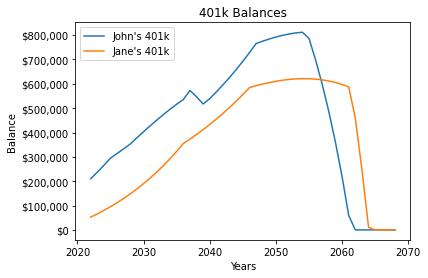

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter

df = pd.DataFrame(index = simulation.simulated_years)
df["John's 401k"] = john.legacy_retirement_accounts[0].stat_balance_history
df["Jane's 401k"] = jane.legacy_retirement_accounts[0].stat_balance_history

ax = df.plot(subplots=False, legend=True)
ax.set_title('401k Balances')
ax.set_ylabel('Balance')
ax.set_xlabel('Years')
y_fmt = StrMethodFormatter('${x:1,.0f}')
ax.yaxis.set_major_formatter(y_fmt)
plt.legend(loc='best')
plt.show()

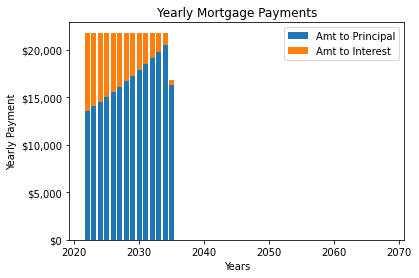

In [ ]:
fig, ax = plt.subplots()
ax.bar(simulation.simulated_years, home.mortgage.stat_principal_payment_history, label="Amt to Principal")
ax.bar(simulation.simulated_years, home.mortgage.stat_interest_payment_history, bottom=home.mortgage.stat_principal_payment_history, label="Amt to Interest")

ax.set_title('Yearly Mortgage Payments')
ax.set_ylabel('Yearly Payment')
ax.set_xlabel('Years')
y_fmt = StrMethodFormatter('${x:1,.0f}')
ax.yaxis.set_major_formatter(y_fmt)
ax.legend()
plt.show()